In [97]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import collections as c
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
import random
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [75]:
log_reg_model = pickle.load(open('logistic_regression_completion_first_half.p', 'rb')) # load the model

In [76]:
log_reg_model.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')>

In [106]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)

def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [78]:
X_test = pd.read_csv('../data/processed/first_half/X_test.csv')
y_test = pd.read_csv('../data/processed/first_half/y_test.csv')
y_test = y_test['module_not_completed']

numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

# fill and scale
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)

high_vif = ['module_presentation_length', 'sum_days_vle_accessed', 'score_first_assessment', 'days_early_first_assessment']
X_test.drop(high_vif, axis = 1, inplace = True)

In [79]:
t = 0.5 # threshold for predicting positive

In [108]:
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = log_reg_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    class_report = classification_report(y_test, predictions)

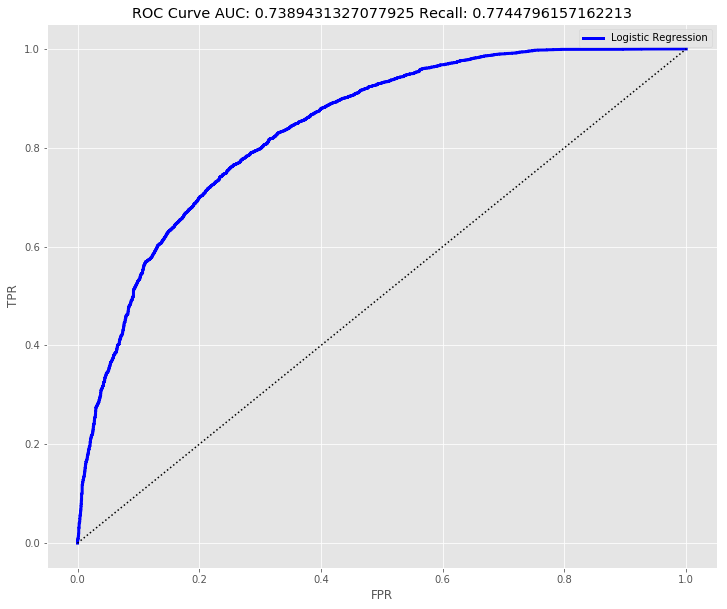

Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')

Roc Auc: 0.7389431327077925

Recall Score: 0.7744796157162213

Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.79      0.88      0.83      5116
        True       0.74      0.60      0.66      3003

   micro avg       0.77      0.77      0.77      8119
   macro avg       0.76      0.74      0.75      8119
weighted avg       0.77      0.77      0.77      8119


Confusion Matrix at Threshold 0.5:
 [[1809  637]
 [1194 4479]]


In [109]:
    print_roc_curve(y_test, probas, 'Logistic Regression')
    print('Best Model: {}'.format(log_reg_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))

## Model Improvement Over Baseline

In [127]:
proportion = y_test.sum() / y_test.shape[0]

In [166]:
# randomly pedict ~1/3 = true
proportion = 0.33567943348158386
baseline_preds = []
for n in range(len(y_test)):
    if random.random() < proportion:
        baseline_preds.append(True)
    else:
        baseline_preds.append(False)

In [167]:
baseline_probas = np.array([proportion] * len(y_test))

In [168]:
    predictions = baseline_preds
    roc_auc = roc_auc_score(y_test, predictions)
    probas = baseline_probas
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

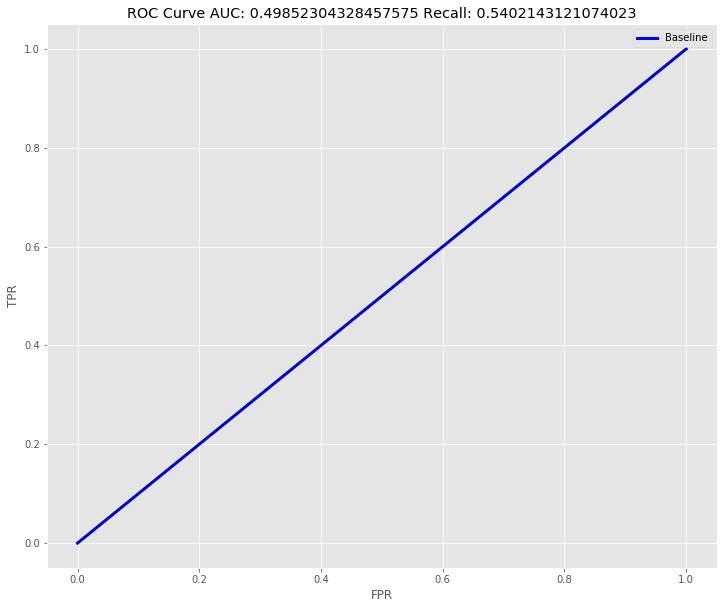


Roc Auc: 0.49852304328457575

Recall Score: 0.5402143121074023

Classification Report:
               precision    recall  f1-score   support

       False       0.63      0.66      0.64      5116
        True       0.37      0.34      0.35      3003

   micro avg       0.54      0.54      0.54      8119
   macro avg       0.50      0.50      0.50      8119
weighted avg       0.53      0.54      0.54      8119


Confusion Matrix:
 [[1016 1746]
 [1987 3370]]


In [170]:
    print_roc_curve(y_test, probas, 'Baseline')
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

## Feature Importance

In [133]:
    # Feature Importances
    abs_coef = list(np.abs(log_reg_model.coef_.ravel()))
    features = list(X_test.columns)
    coef_dict = c.OrderedDict((zip(abs_coef, features)))
    print('The top twenty features affecting completion are:\n')
    sorted(coef_dict.items(), reverse=True)[:20]

The top twenty features affecting completion are:



[(1.3592540035912402, 'avg_score'),
 (1.0766723397761364, 'code_module_FFF'),
 (0.9506949425582728, 'code_module_CCC'),
 (0.8598306856392018, 'code_module_EEE'),
 (0.8335510440095666, 'code_module_DDD'),
 (0.8229766584673477, 'imd_band_nan'),
 (0.7280808568221493, 'code_module_GGG'),
 (0.6186816757568895, 'sum_click_oucontent'),
 (0.5914163001849582, 'highest_education_No Formal quals'),
 (0.5123673482803173, 'highest_education_Lower Than A Level'),
 (0.5104799311737396, 'imd_band_90-100%'),
 (0.4936213392734161, 'code_presentation_2014J'),
 (0.3735437345633287, 'sum_click_homepage'),
 (0.36771469438033877, 'imd_band_80-90%'),
 (0.3676402068054868, 'age_band_55<='),
 (0.3649816187850192, 'imd_band_60-70%'),
 (0.3592557489362496, 'imd_band_50-60%'),
 (0.3586003063446178, 'region_Wales'),
 (0.34119903182952693, 'code_presentation_2013J'),
 (0.3354794312499752, 'imd_band_70-80%')]

## Choosing a Threshold

In [64]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:100]

,fprs,tprs,Thresholds
800,0.153846,0.635457,0.731065
900,0.180486,0.670641,0.708575
1000,0.202797,0.702502,0.686235
1100,0.229104,0.732213,0.661978
1200,0.252414,0.761142,0.635011
1300,0.283383,0.787725,0.609290
1400,0.312354,0.810985,0.584170
1500,0.339660,0.834636,0.559915
1600,0.371295,0.855942,0.531221
1700,0.400266,0.879789,0.495401


In [163]:
    t = 0.5 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.79      0.88      0.83      5116
        True       0.74      0.60      0.66      3003

   micro avg       0.77      0.77      0.77      8119
   macro avg       0.76      0.74      0.75      8119
weighted avg       0.77      0.77      0.77      8119


Confusion Matrix at Threshold 0.5:
 [[1809  637]
 [1194 4479]]


In [164]:
    t = 0.4 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.82      0.80      0.81      5116
        True       0.67      0.70      0.69      3003

   micro avg       0.76      0.76      0.76      8119
   macro avg       0.75      0.75      0.75      8119
weighted avg       0.76      0.76      0.76      8119


Confusion Matrix at Threshold 0.4:
 [[2112 1042]
 [ 891 4074]]


In [165]:
    t = 0.3 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.3:
               precision    recall  f1-score   support

       False       0.86      0.68      0.76      5116
        True       0.60      0.81      0.69      3003

   micro avg       0.73      0.73      0.73      8119
   macro avg       0.73      0.75      0.72      8119
weighted avg       0.76      0.73      0.73      8119


Confusion Matrix at Threshold 0.3:
 [[2434 1629]
 [ 569 3487]]
